<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Functions</a></span></li></ul></li><li><span><a href="#An-example" data-toc-modified-id="An-example-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>An example</a></span></li><li><span><a href="#Test-for-noise" data-toc-modified-id="Test-for-noise-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Test for noise</a></span></li></ul></div>

In [19]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns



from network import Protocol, Network, NetworkNMDA, NetworkManager
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

# Preamble

In [2]:
%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

epsilon = 1e-7
vmin = -6.0
remove = 0.010

strict_maximum = True

dt = 0.001
tau_s = 0.010
tau_a = 0.250
g_I = 3.0
g_a = 2.0
G = 50.0

sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['figure.figsize'] = (12, 8)
lw = 10
ms = 22
alpha_graph = 0.3
colors = sns.color_palette()

## Functions

In [15]:
def run_sigma_sweep(sigma_number, samples, sigma_max, manager, T_persistence=0.050, tau_z_pre=0.025):
    
    hypercolumns = 1
    minicolumns = 5
    n_patterns = minicolumns
    
    dt = 0.001
    tau_s = 0.010
    tau_a = 0.250
    g_I = 3.0
    g_a = 2.0
    G = 50.0
    
    sigma_out = 0.0
    tau_z_pre = tau_z_pre 
    tau_z_post = 0.005

    # Training protocol
    training_times_base = 0.100
    training_times = [training_times_base for i in range(n_patterns)]
    ipi_base = 0.000
    inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
    inter_sequence_interval = 0.0
    resting_time = 0.0
    epochs = 1
    T_persistence = 0.100

    # Manager properties
    values_to_save = ['o']

    # Neural Network
    nn = NetworkNMDA(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                     tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                     strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    # Build the representation
    representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                        inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)
    
    # Run the protocol
    manager.run_network_protocol(protocol=protocol)
    manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence)
    
    tau_s = manager.nn.tau_s
    T_recall = 2 * T_persistence * manager.nn.minicolumns
    T_cue = 2 * tau_s
    nr = manager.canonical_network_representation
    n_patterns = len(nr)

    sigma_vector = np.linspace(0.05, sigma_max, num=sigma_number)

    successes_collection = np.zeros((sigma_number, samples))
    persistent_times_collection = {index: [] for index in range(sigma_number)}
    sequence_collection = {index: [] for index in range(sigma_number)}

    for index, sigma in enumerate(sigma_vector):
        manager.nn.sigma_out = sigma
        manager.nn.sigma_in = sigma * np.sqrt(2 / tau_s)
        for sample in range(samples):
            aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=remove,
                                              reset=True, empty_history=True)
            success, pattern_sequence, persistent_times, timings = aux
            successes_collection[index, sample] = success
            persistent_times_collection[index].append(persistent_times[:n_patterns])
            sequence_collection[index].append(pattern_sequence)

    results_dic = {'manager': manager, 'sigma_vector': sigma_vector, 'success': successes_collection,
                   'persistent times': persistent_times_collection, 'sequences': sequence_collection,
                   'T_persistence': T_persistence}

    return results_dic


def plot_mean_success_vs_sigma(results_dictionary, n_samples, index=0, label=0, ax=None, add_zero_axis=False, 
                               legend=False):

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    successes_collection = results_dictionary['success']
    sigma_vector = results_dictionary['sigma_vector']

    std = successes_collection.std(axis=1)
    mean_success = successes_collection.mean(axis=1)
    ci_low, ci_upp = sm.stats.proportion_confint(mean_success * n_samples, n_samples, alpha=0.05, method='normal')

    # Plot the mean
    ax.plot(sigma_vector, mean_success, 'o-', lw=lw, ms=ms, color=colors[index], label=label)
    
    if False:
        # Plot sigma05
        sigma09_arg = np.where(mean_success <= 0.9)[0]
        if sigma09_arg.size > 0:
            sigma09 = sigma_vector[sigma09_arg[0]]
            ax.plot(sigma09, 0.9, '*', ms=(ms + 20), color='black')

        sigma01_arg = np.where(mean_success <= 0.1)[0]
        if sigma01_arg.size > 0:
            sigma01 = sigma_vector[sigma01_arg[0]]
            ax.plot(sigma01, 0.1, '*', ms=(ms + 20), color='black')
    
    # Plot the interval
    low = ci_low
    low[low < 0.0] = 0.0
    high = ci_upp
    ax.fill_between(sigma_vector, low, high, color=colors[index], alpha=alpha_graph)
    
    if add_zero_axis:
        ax.axhline(0, ls='--', color='gray')
        ax.axvline(0, ls='--', color='gray')
    
    ax.set_xlabel(r'$\sigma$')
    ax.set_ylabel('Success rate')
    
    if legend:
        ax.legend(frameon=False)

    return ax


def plot_persistent_time_vs_sigma(results_dictionary, index=0, label=0, ax=None, single=True, add_zero_axis=False):

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    persistent_times = results_dictionary['persistent times'] 
    sigma_vector = results_dictionary['sigma_vector']
    T_persistence = results_dictionary['T_persistence']
    mean_persistent = np.zeros(sigma_vector.size)
    low = np.zeros(sigma_vector.size)
    high = np.zeros(sigma_vector.size)
    std = np.zeros(sigma_vector.size)
    
    for sigma_index in range(sigma_vector.size):
        flatted = [item for l in persistent_times[sigma_index] for item in l[1:-1]]
        mean_persistent[sigma_index] = np.mean(flatted)
        std[sigma_index] = np.std(flatted)
        low[sigma_index] = np.percentile(flatted, 25)
        high[sigma_index] = np.percentile(flatted, 75)

    ax.plot(sigma_vector, mean_persistent, 'o-', lw=lw, ms=ms, color=colors[index] , label=label)
    ax.fill_between(sigma_vector, low, high,color=colors[index], alpha=alpha_graph)
    if add_zero_axis:
        ax.axhline(0, ls='--',color='gray')
        ax.axvline(0, ls='--',color='gray')
    
    ax.set_xlabel(r'$\sigma$')
    ax.set_ylabel(r'$T_{persistence} (s)$')

    if single:
        ax.axhline(T_persistence, ls='--', color=colors[index], label=r'$T_{base}$' )
        ax.axhline(tau_s, ls='--', color='red', label=r'$\tau_s$')
        ax.legend(frameon=False)
    
    return ax

# An example

../network.py:524: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pattern == epoch_end_string:


pattern sequence [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9]
times [0.055, 0.061, 0.062, 0.061, 0.061, 0.061, 0.061, 0.061, 0.06, 0.258, 0.165, 0.064]
T_calculated 0.0911
CPU times: user 424 ms, sys: 4 ms, total: 428 ms
Wall time: 426 ms


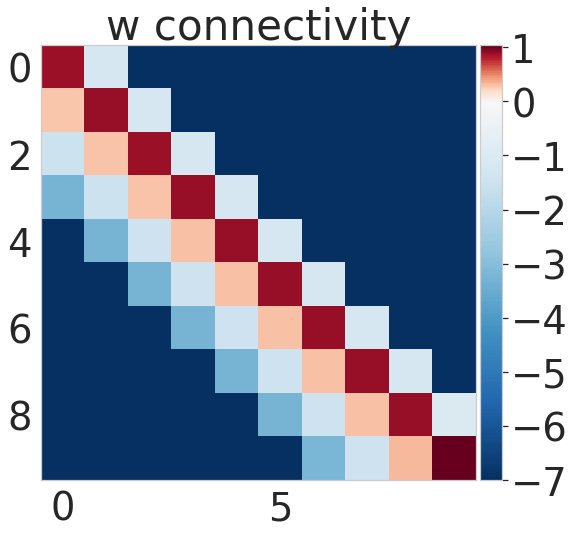

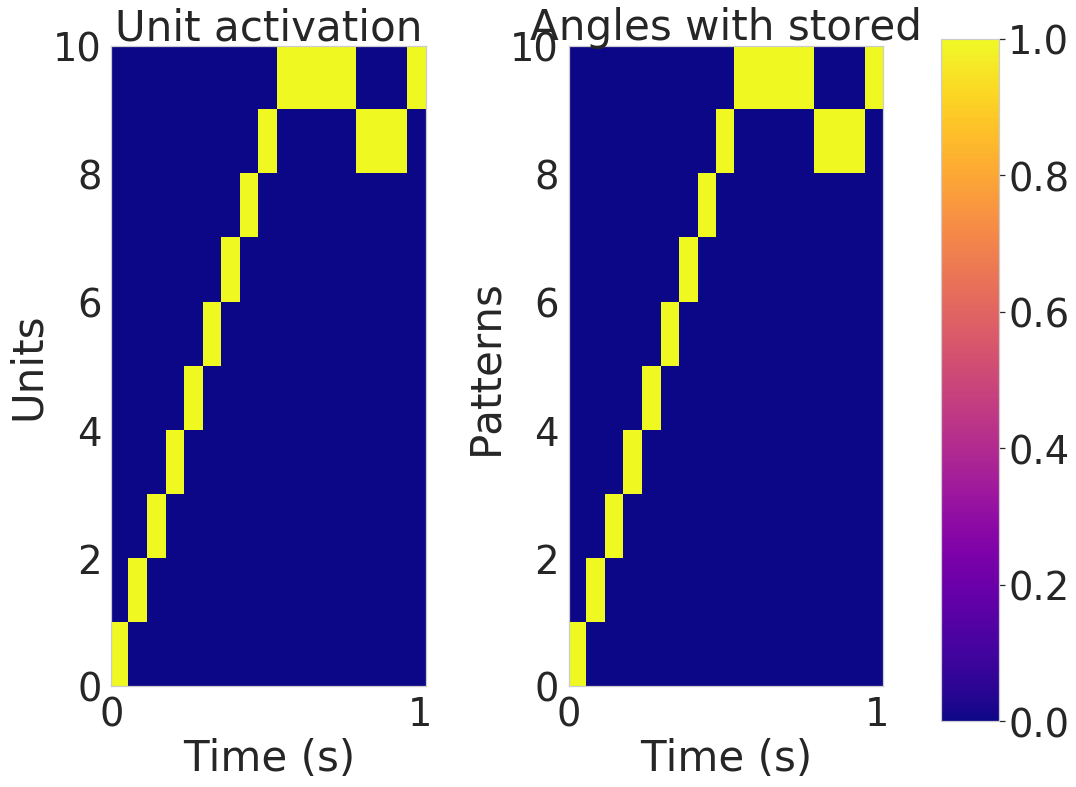

In [14]:
%%time

sigma_out = 0.0
tau_z_pre = 0.025
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 10
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1
T_persistence = 0.100

# Manager properties
values_to_save = ['o', 'i', 'z_pre', 's', 'a', 'beta']

# Neural Network
nn = NetworkNMDA(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

manager.run_network_protocol(protocol=protocol)
plot_weight_matrix(manager)

NMDA_active = True
if not NMDA_active:
    nn.g_NMDA = 0.0

manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, from_state=1, 
                                                 to_state=2, NMDA=NMDA_active)

T_cue = 1.0 * manager.nn.tau_s
T_recall = 1.0 * T_persistence * n_patterns + T_cue


# Success
nr = representation.network_representation
aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success, pattern_sequence, persistent_times, timings = aux

print('pattern sequence', pattern_sequence)
print('times', persistent_times)
print('T_calculated', np.mean(persistent_times[1:-1]))
plot_network_activity_angle(manager, time_y=False);

# Test for noise

In [22]:
%%time

tau_z_pre_set = [0.025, 0.050, 0.075, 0.100]
tau_z_pre_set = [0.025, 0.075, 0.125]
# tau_z_pre_set = [0.025]
T_persistence = 0.050
results_dictionary_collection_tp = {}
sigma_number = 20
samples = 500
sigma_max = 1.0

for tau_z_pre in tau_z_pre_set:
    print(tau_z_pre)
    results_dictionary= run_sigma_sweep(sigma_number, samples, sigma_max, manager, 
                                        T_persistence=T_persistence, tau_z_pre=tau_z_pre)  
    results_dictionary_collection_tp[tau_z_pre] = results_dictionary

0.025


../network.py:524: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pattern == epoch_end_string:


0.075
0.125
CPU times: user 52min 23s, sys: 632 ms, total: 52min 24s
Wall time: 52min 24s


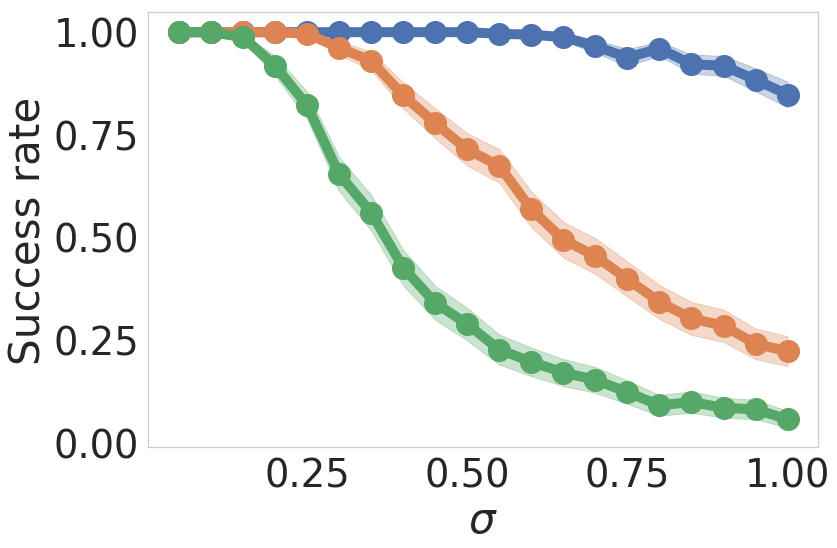

In [23]:
results_dictionary_collection = results_dictionary_collection_tp
ax = None
for index, tau_z_pre in enumerate(tau_z_pre_set):
    label = r'$\tau_{z_{pre}}$ = ' + str(tau_z_pre)
    results_dictionary = results_dictionary_collection[tau_z_pre]
    ax = plot_mean_success_vs_sigma(results_dictionary, n_samples=samples, index=index, label=label, ax=ax)

Text(0, 0.5, '$T_{per}$')

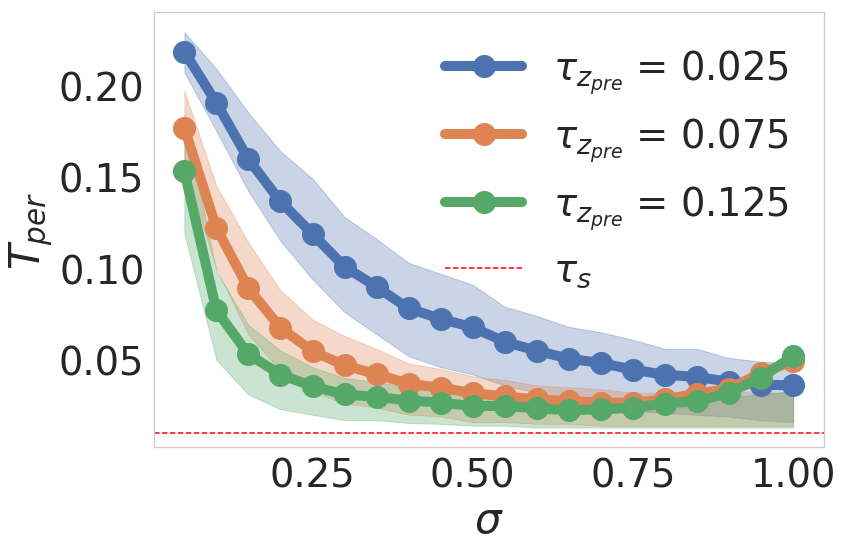

In [24]:
results_dictionary_collection = results_dictionary_collection_tp
ax = None
for index, tau_z_pre in enumerate(tau_z_pre_set):
    label = r'$\tau_{z_{pre}}$ = ' + str(tau_z_pre)
    results_dictionary = results_dictionary_collection[tau_z_pre]
    ax = plot_persistent_time_vs_sigma(results_dictionary, index=index, label=label, ax=ax, single=False)

ax.axhline(tau_s, ls='--', color='red', label=r'$\tau_s$')
ax.legend(frameon=False)
ax.set_ylabel(r'$T_{per}$')